# load data

In [1]:
import pandas as pd

In [2]:
pip install openpyxl


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
gage_class=pd.read_excel('../data/raw/streamflow/GAGES-II_ref_non_ref.xlsx')
gage_class.head()

,STAID,CLASS
0,1011000,Non-ref
1,1013500,Ref
2,1015800,Non-ref
3,1016500,Non-ref
4,1017000,Non-ref


In [17]:
gage_in_gslb=pd.read_csv('../data/raw/streamflow/gsl_nwm_gage.csv')
gage_in_gslb.head()

,id,name,River,latitude,longitude,elevation_m,state
0,10011200,WEST FORK BEAR RIVER AT WHITNEY DAM - NR OAKLE...,WEST FORK BEAR RIVER,40.841614,-110.927119,2797,Utah
1,10011500,BEAR RIVER NEAR UTAH-WYOMING STATE LINE,BEAR RIVER,40.965225,-110.853508,2432,Utah
2,10015700,SULPHUR CR.AB.RES.BL.LA CHAPELLE CR.NR EVANSTO...,SULPHUR CREEK,41.129114,-110.806563,2205,Wyoming
3,10015900,SULPHUR CREEK BL RES. - NEAR EVANSTON - WYO.,SULPHUR CREEK,41.156058,-110.835176,2173,Wyoming
4,10016900,BEAR RIVER AT EVANSTON - WY,BEAR RIVER,41.270224,-110.963793,2057,Wyoming


In [18]:
import pandas as pd

# Check the initial assignment
print("Loading gage_class from Excel file...")
try:
    gage_class = pd.read_excel('../data/raw/streamflow/GAGES-II_ref_non_ref.xlsx')
    print("Successfully loaded gage_class as DataFrame")
except Exception as e:
    print(f"Error loading gage_class: {e}")

# Check the type and value of gage_class
print(f"Type of gage_class after loading: {type(gage_class)}")
print(gage_class.head())

# Ensure gage_class is not overwritten
# Add similar checks throughout your code where gage_class is used


Loading gage_class from Excel file...
Successfully loaded gage_class as DataFrame
Type of gage_class after loading: <class 'pandas.core.frame.DataFrame'>
     STAID    CLASS
0  1011000  Non-ref
1  1013500      Ref
2  1015800  Non-ref
3  1016500  Non-ref
4  1017000  Non-ref


In [19]:
# Ensure the necessary columns are of string type for merging
gage_class['STAID'] = gage_class['STAID'].astype(str)
gage_in_gslb['id'] = gage_in_gslb['id'].astype(str)

# Merge gage_in_gslb with gage_class to include the class information
gage_in_gslb_with_class = gage_in_gslb.merge(
    gage_class[['STAID', 'CLASS']],
    left_on='id',
    right_on='STAID',
    how='left'
)

# Drop the duplicate STAID column and rename CLASS to lowercase
gage_in_gslb_with_class = gage_in_gslb_with_class.drop('STAID', axis=1)
gage_in_gslb_with_class = gage_in_gslb_with_class.rename(columns={'CLASS': 'class'})

# Calculate the total number of gages
total_gages = len(gage_in_gslb_with_class)

# Count the number of gages in each class
class_counts = gage_in_gslb_with_class['class'].value_counts()

# Calculate the percentage of gages in each class
class_percentages = (class_counts / total_gages) * 100

# Display the results
print("Number of gages in each class:")
print(class_counts)
print("\nPercentage of gages in each class:")
print(class_percentages.round(2), "%")


Number of gages in each class:
class
Non-ref    69
Ref         9
Name: count, dtype: int64

Percentage of gages in each class:
class
Non-ref    88.46
Ref        11.54
Name: count, dtype: float64 %


In [20]:
# Get the reference gages that are within the GSL basin
ref_gages_in_gslb = gage_in_gslb_with_class[gage_in_gslb_with_class['class'] == 'Ref']

# Display the reference gages in GSL basin with their details
ref_gages_in_gslb[['id', 'name', 'River', 'latitude', 'longitude', 'state', 'class']]

,id,name,River,latitude,longitude,state,class
7,10023000,BIG CREEK NEAR RANDOLPH - UT,BIG CREEK,41.609942,-111.254088,Utah,Ref
13,10041000,THOMAS FORK NEAR WYOMING-IDAHO STATE LINE,THOMAS FORK,42.402708,-111.025749,Wyoming,Ref
16,10058600,BLOOMINGTON CREEK AT BLOOMINGTON - ID,BLOOMINGTON CREEK,42.184650,-111.425763,Idaho,Ref
20,10093000,CUB RIVER NEAR PRESTON - ID,CUB RIVER,42.141037,-111.689388,Idaho,Ref
27,10109001,COM F LOGAN R AB ST D AND LO HP AND SM C N LO UT,COM FORK LOGAN RIVER,41.744375,-111.784387,Utah,Ref
51,10143500,CENTERVILLE CREEK ABV. DIV NEAR CENTERVILLE - UT,CENTERVILLE CREEK,40.916334,-111.862993,Utah,Ref
54,10148200,TIE FORK NEAR SOLDIER SUMMIT - UT,TIE FORK,39.949958,-111.216839,Utah,Ref
75,10172700,VERNON CREEK NEAR VERNON - UT,VERNON CREEK,39.979391,-112.380230,Utah,Ref
76,10172860,WARM CREEK NEAR GANDY - UT,WARM CREEK,39.459528,-114.023722,Utah,Ref


# plots

In [21]:
final_result_cleaned = pd.read_csv('../data/features/q_buffer2_pair_delta_30m.csv')

In [22]:
# Convert gage_id in both dataframes to string for merging
final_result_cleaned['gage_id'] = final_result_cleaned['gage_id'].astype(str)
gage_class['STAID'] = gage_class['STAID'].astype(str)

# Merge final_result_cleaned with gage_class to add CLASS column
final_result_cleaned = final_result_cleaned.merge(
    gage_class[['STAID', 'CLASS']],
    left_on='gage_id',
    right_on='STAID',
    how='left'
)

# Drop redundant STAID column and rename CLASS to lowercase
final_result_cleaned.drop('STAID', axis=1, inplace=True)
final_result_cleaned.rename(columns={'CLASS': 'class'}, inplace=True)


In [23]:
# Count the number of Non-ref and Ref gages
gage_counts = final_result_cleaned['class'].value_counts()

# Display the counts
print("Number of Non-ref gages:", gage_counts.get('Non-ref', 0))
print("Number of Ref gages:", gage_counts.get('Ref', 0))


Number of Non-ref gages: 2308800
Number of Ref gages: 39283


In [24]:
final_result_cleaned.head()

,well_id,date,wte,gse,gage_id,well_lat,well_lon,gage_lat,gage_lon,wte_meters,q,bfd,delta_wte,delta_q,class
0,411605111481601,1932-08-08,4833.810000,4840.0,10141000,41.267997,-111.805216,41.278277,-112.091887,1473.345288,38.0,1.0,0.000000,0.0,Non-ref
1,411605111481601,1932-08-09,4833.807273,4840.0,10141000,41.267997,-111.805216,41.278277,-112.091887,1473.344457,38.0,1.0,-0.002727,0.0,Non-ref
2,411605111481601,1932-08-10,4833.804630,4840.0,10141000,41.267997,-111.805216,41.278277,-112.091887,1473.343651,34.0,1.0,-0.005370,-4.0,Non-ref
3,411605111481601,1932-08-11,4833.802070,4840.0,10141000,41.267997,-111.805216,41.278277,-112.091887,1473.342871,9.0,1.0,-0.007930,-29.0,Non-ref
4,411605111481601,1932-08-12,4833.799591,4840.0,10141000,41.267997,-111.805216,41.278277,-112.091887,1473.342115,9.0,1.0,-0.010409,-29.0,Non-ref


In [25]:
final_result_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2348083 entries, 0 to 2348082
Data columns (total 15 columns):
 #   Column      Dtype  
---  ------      -----  
 0   well_id     int64  
 1   date        object 
 2   wte         float64
 3   gse         float64
 4   gage_id     object 
 5   well_lat    float64
 6   well_lon    float64
 7   gage_lat    float64
 8   gage_lon    float64
 9   wte_meters  float64
 10  q           float64
 11  bfd         float64
 12  delta_wte   float64
 13  delta_q     float64
 14  class       object 
dtypes: float64(11), int64(1), object(3)
memory usage: 268.7+ MB


In [26]:
# 高效的一次性数据准备和绘图
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
import matplotlib.dates as mdates
import os
from matplotlib.patches import Patch

print("=== 高效数据准备 ===")

# 检查数据是否已经有class列，避免重复merge
if 'class' not in final_result_cleaned.columns:
    print("添加class信息...")
    # 确保数据类型一致
    final_result_cleaned['gage_id'] = final_result_cleaned['gage_id'].astype(str)
    gage_class['STAID'] = gage_class['STAID'].astype(str)
    
    # Merge to add CLASS column
    final_result_cleaned = final_result_cleaned.merge(
        gage_class[['STAID', 'CLASS']],
        left_on='gage_id',
        right_on='STAID',
        how='left'
    )
    
    # Clean up and rename
    final_result_cleaned.drop('STAID', axis=1, inplace=True)
    final_result_cleaned.rename(columns={'CLASS': 'class'}, inplace=True)
else:
    print("class列已存在，跳过merge...")

# 一次性进行datetime转换
if final_result_cleaned['date'].dtype == 'object':
    print("转换日期格式...")
    final_result_cleaned['date'] = pd.to_datetime(final_result_cleaned['date'])

# 确保目录存在
os.makedirs('../reports/figures/scatter_plots_delta_q_delta_wte', exist_ok=True)

# 高效的分组绘图
print("开始生成散点图...")
stats_data = []
grouped = final_result_cleaned.groupby('gage_id')

for gage_id, group in grouped:
    # 一次性清理数据
    group = group.dropna(subset=['delta_wte', 'delta_q'])
    
    if len(group) < 2:
        continue
        
    # 创建图表
    plt.figure(figsize=(12, 6))

    # 高效绘图 - 减少不必要的参数
    sns.scatterplot(
        data=group,
        x='delta_wte',
        y='delta_q',
        hue='well_id',
        palette='viridis',
        legend=False,
        alpha=0.6
    )

    # 回归分析
    if len(group['delta_wte'].unique()) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(
            group['delta_wte'], group['delta_q']
        )

        # 绘制回归线
        x_range = [group['delta_wte'].min(), group['delta_wte'].max()]
        y_range = [intercept + slope * x for x in x_range]
        plt.plot(x_range, y_range, 'r-', linewidth=2)

        # 获取class信息（安全方式）
        class_value = group['class'].iloc[0] if len(group) > 0 and 'class' in group.columns else 'Unknown'

        # 收集统计数据
        stats_data.append({
            'gage_id': gage_id,
            'num_wells': group['well_id'].nunique(),
            'num_measurements': len(group),
            'slope': slope,
            'intercept': intercept,
            'r_squared': r_value ** 2,
            'p_value': p_value,
            'class': class_value
        })

        legend_text = (
            f"Wells: {group['well_id'].nunique()}\n"
            f"Measurements: {len(group)}\n"
            f"Slope: {slope:.2f}\n"
            f"R²: {r_value ** 2:.2f}\n"
            f"p-value: {p_value:.4f}"
        )
    else:
        legend_text = (
            f"Wells: {group['well_id'].nunique()}\n"
            f"Measurements: {len(group)}\n"
            "No variation in delta_wte"
        )

    # 显示class信息
    class_display = 'Unknown'
    if 'class' in group.columns and len(group) > 0:
        class_val = group['class'].iloc[0]
        if class_val == 'Non-ref':
            class_display = 'Unregulated'
        elif class_val == 'Ref':
            class_display = 'Regulated'
        else:
            class_display = str(class_val) if pd.notna(class_val) else 'Unknown'

    # 设置图表
    plt.title(f'Gage ID: {gage_id} - Class: {class_display}')
    plt.xlabel('Delta WTE (ft)')
    plt.ylabel('Delta Q (cfs)')
    plt.grid(True, alpha=0.3)

    # 添加统计信息
    plt.text(
        0.98, 0.95, legend_text,
        transform=plt.gca().transAxes,
        fontsize=10, ha='right', va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )

    # 保存图表
    plt.savefig(f'../reports/figures/scatter_plots_delta_q_delta_wte/gage_{gage_id}.png', 
                bbox_inches='tight', dpi=150)
    plt.close()

# 导出统计数据
if stats_data:
    stats_df = pd.DataFrame(stats_data)
    stats_df.to_csv('../reports/figures/scatter_plots_delta_q_delta_wte/scatter_delta_q_delta_wte_statistics_optimized.csv', index=False)
    print(f"生成了 {len(stats_data)} 个图表并保存统计数据")
else:
    print("没有足够的数据生成图表")

print("绘图完成！")

=== 高效数据准备 ===
class列已存在，跳过merge...
转换日期格式...
开始生成散点图...
生成了 6 个图表并保存统计数据
绘图完成！


## Monthly

### time series

In [27]:
final_result_cleaned.head()

,well_id,date,wte,gse,gage_id,well_lat,well_lon,gage_lat,gage_lon,wte_meters,q,bfd,delta_wte,delta_q,class
0,411605111481601,1932-08-08,4833.810000,4840.0,10141000,41.267997,-111.805216,41.278277,-112.091887,1473.345288,38.0,1.0,0.000000,0.0,Non-ref
1,411605111481601,1932-08-09,4833.807273,4840.0,10141000,41.267997,-111.805216,41.278277,-112.091887,1473.344457,38.0,1.0,-0.002727,0.0,Non-ref
2,411605111481601,1932-08-10,4833.804630,4840.0,10141000,41.267997,-111.805216,41.278277,-112.091887,1473.343651,34.0,1.0,-0.005370,-4.0,Non-ref
3,411605111481601,1932-08-11,4833.802070,4840.0,10141000,41.267997,-111.805216,41.278277,-112.091887,1473.342871,9.0,1.0,-0.007930,-29.0,Non-ref
4,411605111481601,1932-08-12,4833.799591,4840.0,10141000,41.267997,-111.805216,41.278277,-112.091887,1473.342115,9.0,1.0,-0.010409,-29.0,Non-ref


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import os

# Ensure the plots directory exists
os.makedirs('downstream/all/monthly/subplot_q_delta_wte_monthly', exist_ok=True)

# Prepare a list to collect statistical data for CSV
stats_data = []

# Assuming final_result_cleaned is already loaded as a DataFrame
# Group by gage_id
grouped = final_result_cleaned.groupby('gage_id')

# Iterate over each group
for gage_id, group in grouped:
    # Drop NaN values (changed from 'q' to 'delta_q')
    group = group.dropna(subset=['delta_wte', 'date', 'delta_q'])

    # Convert date to datetime format
    group['date'] = pd.to_datetime(group['date'])

    # Extract month from date
    group['month'] = group['date'].dt.month
    group['month_name'] = group['date'].dt.strftime('%B')

    # Sort by date to ensure the line plot is correct
    group = group.sort_values('date')

    # Get unique months in the data
    unique_months = sorted(group['month'].unique())

    # Skip if no monthly data
    if len(unique_months) == 0:
        continue

    # Create plots for each month
    for month in unique_months:
        # Filter data for current month
        monthly_data = group[group['month'] == month].copy()
        month_name = monthly_data['month_name'].iloc[0]

        # Skip if insufficient data for this month
        if len(monthly_data) < 2:
            continue

        # Create subplots (Delta Q on top, Delta WTE on bottom)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

        # Plot delta_q vs. date on the top subplot (changed from q)
        ax1.scatter(monthly_data['date'], monthly_data['delta_q'], color='orange', label='Delta Q (cfs)', alpha=0.6)

        # Perform linear regression for delta_q (changed from q)
        if len(monthly_data) > 1 and len(monthly_data['date'].unique()) > 1:
            monthly_data['date_numeric'] = monthly_data['date'].map(pd.Timestamp.toordinal)
            slope_delta_q, intercept_delta_q, r_value_delta_q, p_value_delta_q, std_err_delta_q = linregress(
                monthly_data['date_numeric'], monthly_data['delta_q']
            )

            # Plot the regression line for delta_q
            ax1.plot(monthly_data['date'],
                    intercept_delta_q + slope_delta_q * monthly_data['date_numeric'],
                    'r', label='Fitted line for Delta Q')

            # Prepare legend text for delta_q
            legend_text_delta_q = (
                f"Delta Q Points: {len(monthly_data)}\n"
                f"Slope Delta Q: {slope_delta_q:.6f}\n"
                f"R² Delta Q: {r_value_delta_q ** 2:.2f}\n"
                f"P-value Delta Q: {p_value_delta_q:.4f}"
            )
        else:
            slope_delta_q = r_value_delta_q = p_value_delta_q = None
            legend_text_delta_q = (
                f"Delta Q Points: {len(monthly_data)}\n"
                "Insufficient data for regression"
            )

        ax1.set_ylabel('Delta Q (cfs)')
        ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

        # Add a custom legend with statistical data for delta_q
        ax1.text(
            0.05, 0.95,
            legend_text_delta_q,
            transform=ax1.transAxes,
            fontsize=10,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
        )

        # Plot delta_wte vs. date on the bottom subplot
        ax2.scatter(monthly_data['date'], monthly_data['delta_wte'], color='blue', label='Delta WTE', alpha=0.6)

        # Perform linear regression for delta_wte
        if len(monthly_data) > 1 and len(monthly_data['date'].unique()) > 1:
            slope_wte, intercept_wte, r_value_wte, p_value_wte, std_err_wte = linregress(
                monthly_data['date_numeric'], monthly_data['delta_wte']
            )

            # Plot the regression line for delta_wte
            ax2.plot(monthly_data['date'],
                    intercept_wte + slope_wte * monthly_data['date_numeric'],
                    'r', label='Fitted line for Delta WTE')

            # Collect statistics (updated variable names)
            stats_data.append({
                'gage_id': gage_id,
                'month': month,
                'month_name': month_name,
                'num_wells': monthly_data['well_id'].nunique(),
                'num_measurements': len(monthly_data),
                'slope_delta_q': slope_delta_q,
                'r_squared_delta_q': r_value_delta_q ** 2 if r_value_delta_q is not None else None,
                'p_value_delta_q': p_value_delta_q,
                'slope_wte': slope_wte,
                'r_squared_wte': r_value_wte ** 2,
                'p_value_wte': p_value_wte
            })

            # Prepare legend text for delta_wte
            legend_text_wte = (
                f"Wells: {monthly_data['well_id'].nunique()}\n"
                f"Measurements: {len(monthly_data)}\n"
                f"Slope WTE: {slope_wte:.6f}\n"
                f"R² WTE: {r_value_wte ** 2:.2f}\n"
                f"P-value WTE: {p_value_wte:.4f}"
            )
        else:
            legend_text_wte = (
                f"Wells: {monthly_data['well_id'].nunique()}\n"
                f"Measurements: {len(monthly_data)}\n"
                "Insufficient data for regression"
            )

        ax2.set_ylabel('Delta WTE (ft)')
        ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

        # Add a custom legend with statistical data for delta_wte
        ax2.text(
            0.05, 0.95,
            legend_text_wte,
            transform=ax2.transAxes,
            fontsize=10,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
        )

        # Set a single title for both subplots, closer to the plots (updated title)
        fig.suptitle(f'Gage ID: {gage_id} - {month_name} - Delta Q and Delta WTE vs. Time',
                    fontsize=16, y=0.92)

        # Format the date axis
        ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_major_locator(plt.matplotlib.dates.AutoDateLocator())
        plt.xticks(rotation=45)

        # Save the plot (updated filename)
        plt.savefig(f'downstream/all/monthly/subplot_q_delta_wte_monthly/gage_{gage_id}_{month:02d}_{month_name}.png',
                   bbox_inches='tight')
        plt.close()

# Export statistics to CSV (updated filename)
if stats_data:
    stats_df = pd.DataFrame(stats_data)
    stats_df.to_csv('downstream/all/monthly/delta_q_delta_wte_monthly_statistics.csv', index=False)

    # Calculate monthly statistics (updated variable names)
    print("Monthly Summary Statistics:")
    for month_name in sorted(stats_df['month_name'].unique()):
        month_data = stats_df[stats_df['month_name'] == month_name]

        print(f"\n{month_name}:")
        print(f"  Number of gages: {len(month_data)}")
        print(f"  Average R² Delta Q: {month_data['r_squared_delta_q'].mean():.3f}")
        print(f"  Average R² WTE: {month_data['r_squared_wte'].mean():.3f}")
        print(f"  Positive slope Delta Q: {(month_data['slope_delta_q'] > 0).mean() * 100:.1f}%")
        print(f"  Positive slope WTE: {(month_data['slope_wte'] > 0).mean() * 100:.1f}%")

    # Overall statistics (updated variable names)
    overall_positive_delta_q = (stats_df['slope_delta_q'] > 0).mean() * 100
    overall_positive_wte = (stats_df['slope_wte'] > 0).mean() * 100

    print(f"\nOverall Statistics:")
    print(f"Total gage-month combinations: {len(stats_df)}")
    print(f"Percentage of positive slopes for Delta Q: {overall_positive_delta_q:.2f}%")
    print(f"Percentage of positive slopes for Delta WTE: {overall_positive_wte:.2f}%")

else:
    print("No statistical data collected - insufficient data for regression analysis")


Monthly Summary Statistics:

April:
  Number of gages: 6
  Average R² Delta Q: 0.070
  Average R² WTE: 0.046
  Positive slope Delta Q: 33.3%
  Positive slope WTE: 0.0%

August:
  Number of gages: 6
  Average R² Delta Q: 0.062
  Average R² WTE: 0.046
  Positive slope Delta Q: 33.3%
  Positive slope WTE: 16.7%

December:
  Number of gages: 6
  Average R² Delta Q: 0.080
  Average R² WTE: 0.052
  Positive slope Delta Q: 33.3%
  Positive slope WTE: 16.7%

February:
  Number of gages: 6
  Average R² Delta Q: 0.097
  Average R² WTE: 0.056
  Positive slope Delta Q: 50.0%
  Positive slope WTE: 16.7%

January:
  Number of gages: 6
  Average R² Delta Q: 0.089
  Average R² WTE: 0.053
  Positive slope Delta Q: 50.0%
  Positive slope WTE: 16.7%

July:
  Number of gages: 6
  Average R² Delta Q: 0.047
  Average R² WTE: 0.047
  Positive slope Delta Q: 16.7%
  Positive slope WTE: 16.7%

June:
  Number of gages: 6
  Average R² Delta Q: 0.049
  Average R² WTE: 0.059
  Positive slope Delta Q: 16.7%
  Posit

### scatter plots

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import os

# Ensure output directory exists
os.makedirs('../reports/figures/monthly/scatter_plots_delta_q_vs_delta_wte', exist_ok=True)

# Load data
final_result_cleaned = pd.read_csv('../data/features/q_buffer2_pair_delta_30m.csv')
gage_class = pd.read_excel('../data/raw/streamflow/GAGES-II_ref_non_ref.xlsx')

# Merge gage classification information
final_result_cleaned['gage_id'] = final_result_cleaned['gage_id'].astype(str)
gage_class['STAID'] = gage_class['STAID'].astype(str)

final_result_cleaned = final_result_cleaned.merge(
    gage_class[['STAID', 'CLASS']],
    left_on='gage_id',
    right_on='STAID',
    how='left'
)

final_result_cleaned.drop('STAID', axis=1, inplace=True)
final_result_cleaned.rename(columns={'CLASS': 'class'}, inplace=True)

# Add month information
final_result_cleaned['date'] = pd.to_datetime(final_result_cleaned['date'])
final_result_cleaned['month'] = final_result_cleaned['date'].dt.month

# Month name mapping
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# Prepare statistics collection
stats_data = []

# Group by gage_id
grouped = final_result_cleaned.groupby('gage_id')

# Create monthly scatter plots for each gage
for gage_id, group in grouped:
    group = group.dropna(subset=['delta_wte', 'delta_q'])

    # Check if enough data is available
    if len(group) < 2:
        continue

    plt.figure(figsize=(15, 10))

    # Get available months for this gage
    available_months = sorted(group['month'].unique())

    # Adjust subplot layout based on number of months
    if len(available_months) <= 4:
        rows, cols = 2, 2
    elif len(available_months) <= 6:
        rows, cols = 2, 3
    elif len(available_months) <= 9:
        rows, cols = 3, 3
    else:
        rows, cols = 3, 4

    fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
    if rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    axes = axes.flatten()

    # Map class display names
    if 'class' in group.columns and not group['class'].isna().all():
        class_display = group['class'].iloc[0]
        if class_display == 'Non-ref':
            class_display = 'Unregulated'
        elif class_display == 'Ref':
            class_display = 'Regulated'
    else:
        class_display = 'Unknown'

    # Create scatter plots for each month
    for idx, month in enumerate(available_months):
        if idx >= len(axes):
            break

        ax = axes[idx]
        month_data = group[group['month'] == month]

        if len(month_data) == 0:
            ax.set_visible(False)
            continue

        # Plot scatter with different colors for each well
        sns.scatterplot(
            data=month_data,
            x='delta_wte',
            y='delta_q',
            hue='well_id',
            palette='viridis',
            edgecolor='none',
            legend=False,
            ax=ax
        )

        legend_text = ""

        # Perform linear regression if enough data points
        if len(month_data) >= 2 and len(month_data['delta_wte'].unique()) > 1:
            slope, intercept, r_value, p_value, std_err = linregress(
                month_data['delta_wte'], month_data['delta_q']
            )

            # Plot regression line
            delta_wte_range = pd.Series(month_data['delta_wte'].unique()).sort_values()
            ax.plot(delta_wte_range, intercept + slope * delta_wte_range, 'r', linewidth=2)

            # Collect statistics
            stats_data.append({
                'gage_id': gage_id,
                'month': month,
                'month_name': month_names[month],
                'num_wells': month_data['well_id'].nunique(),
                'num_measurements': len(month_data),
                'slope': slope,
                'intercept': intercept,
                'r_squared': r_value ** 2,
                'p_value': p_value,
                'class': class_display
            })

            legend_text = (
                f"Wells: {month_data['well_id'].nunique()}\n"
                f"Measurements: {len(month_data)}\n"
                f"Slope: {slope:.2f}\n"
                f"R²: {r_value ** 2:.2f}\n"
                f"p-value: {p_value:.4f}"
            )
        else:
            if len(month_data['delta_wte'].unique()) == 1:
                legend_text = (
                    f"Wells: {month_data['well_id'].nunique()}\n"
                    f"Measurements: {len(month_data)}\n"
                    "All delta_wte identical\nNo regression"
                )
            else:
                legend_text = (
                    f"Wells: {month_data['well_id'].nunique()}\n"
                    f"Measurements: {len(month_data)}\n"
                    "Not enough data"
                )

        # Set subplot labels and title
        ax.set_title(f'{month_names[month]}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Delta WTE (ft)', fontsize=10)
        ax.set_ylabel('Delta Q (cfs)', fontsize=10)

        # Add grid
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        ax.xaxis.grid(False)
        ax.set_facecolor('white')

        # Add statistics text box
        ax.text(
            0.98, 0.95,
            legend_text,
            transform=ax.transAxes,
            fontsize=8,
            ha='right',
            va='top',
            linespacing=1.2,
            bbox=dict(
                facecolor='white',
                edgecolor='black',
                alpha=0.75,
                boxstyle='square,pad=0.3'
            )
        )

    # Hide unused subplots
    for idx in range(len(available_months), len(axes)):
        axes[idx].set_visible(False)

    # Set main title
    fig.suptitle(f'Gage ID: {gage_id} - Class: {class_display}\nDelta Q vs Delta WTE by Month',
                 fontsize=16, fontweight='bold', y=0.95)

    # Adjust layout and save plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.savefig(f'../reports/figures/monthly/scatter_plots_delta_q_vs_delta_wte/gage_{gage_id}_monthly.png',
                bbox_inches='tight', dpi=300)
    plt.close()

# Export statistics
if stats_data:
    stats_df = pd.DataFrame(stats_data)
    stats_df.to_csv('../reports/figures/monthly/scatter_delta_q_vs_delta_wte_monthly_statistics.csv', index=False)

    # Calculate summary statistics
    print(f"Generated monthly scatter plots for {len(grouped)} gages")
    print(f"Total monthly analyses: {len(stats_data)}")

    # Monthly statistics
    monthly_summary = stats_df.groupby('month_name').agg({
        'gage_id': 'count',
        'slope': ['mean', 'std'],
        'r_squared': ['mean', 'std'],
        'p_value': lambda x: (x < 0.05).sum()
    }).round(4)

    print("\nMonthly Summary:")
    print(monthly_summary)

    # Class statistics
    if 'class' in stats_df.columns:
        class_summary = stats_df.groupby('class').agg({
            'gage_id': 'count',
            'slope': ['mean', 'std'],
            'r_squared': ['mean', 'std'],
            'p_value': lambda x: (x < 0.05).sum()
        }).round(4)

        print("\nClass Summary:")
        print(class_summary)
else:
    print("No valid data found for analysis")


Generated monthly scatter plots for 6 gages
Total monthly analyses: 72

Monthly Summary:
           gage_id   slope         r_squared          p_value
             count    mean     std      mean     std <lambda>
month_name                                                   
April            6  0.0396  0.6562    0.0159  0.0155        5
August           6  0.4223  0.7954    0.0135  0.0179        6
December         6  0.1947  0.5695    0.0254  0.0474        6
February         6  0.0873  0.4828    0.0238  0.0430        5
January          6  0.0967  0.6043    0.0256  0.0433        6
July             6  0.3870  0.7467    0.0116  0.0137        6
June             6  0.2902  0.6374    0.0181  0.0257        5
March            6  0.3258  1.1225    0.0181  0.0178        5
May              6  0.1949  0.6706    0.0081  0.0071        5
November         6  0.3017  0.8560    0.0247  0.0406        6
October          6  0.5046  0.9704    0.0194  0.0305        6
September        6  0.4436  0.8475    0.019

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

# Seasonal

### time series

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import os

# Ensure the plots directory exists
os.makedirs('downstream/all/seasonal/subplot_delta_q_delta_wte_seasonal', exist_ok=True)

# Prepare a list to collect statistical data for CSV
stats_data = []

# Define season mapping function
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Assuming final_result_cleaned is already loaded as a DataFrame
# Group by gage_id
grouped = final_result_cleaned.groupby('gage_id')

# Iterate over each group
for gage_id, group in grouped:
    # Drop NaN values (changed from 'q' to 'delta_q')
    group = group.dropna(subset=['delta_wte', 'date', 'delta_q'])

    # Convert date to datetime format
    group['date'] = pd.to_datetime(group['date'])

    # Extract month and season from date
    group['month'] = group['date'].dt.month
    group['season'] = group['month'].apply(get_season)

    # Sort by date to ensure the line plot is correct
    group = group.sort_values('date')

    # Get unique seasons in the data
    unique_seasons = sorted(group['season'].unique())

    # Skip if no seasonal data
    if len(unique_seasons) == 0:
        continue

    # Create plots for each season
    for season in unique_seasons:
        # Filter data for current season
        seasonal_data = group[group['season'] == season].copy()

        # Skip if insufficient data for this season
        if len(seasonal_data) < 2:
            continue

        # Create subplots (Delta Q on top, Delta WTE on bottom)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

        # Plot delta_q vs. date on the top subplot (changed from q)
        ax1.scatter(seasonal_data['date'], seasonal_data['delta_q'], color='orange', label='Delta Q (cfs)', alpha=0.6)

        # Perform linear regression for delta_q (changed from q)
        if len(seasonal_data) > 1 and len(seasonal_data['date'].unique()) > 1:
            seasonal_data['date_numeric'] = seasonal_data['date'].map(pd.Timestamp.toordinal)
            slope_delta_q, intercept_delta_q, r_value_delta_q, p_value_delta_q, std_err_delta_q = linregress(
                seasonal_data['date_numeric'], seasonal_data['delta_q']
            )

            # Plot the regression line for delta_q
            ax1.plot(seasonal_data['date'],
                    intercept_delta_q + slope_delta_q * seasonal_data['date_numeric'],
                    'r', label='Fitted line for Delta Q')

            # Prepare legend text for delta_q
            legend_text_delta_q = (
                f"Delta Q Points: {len(seasonal_data)}\n"
                f"Slope Delta Q: {slope_delta_q:.6f}\n"
                f"R² Delta Q: {r_value_delta_q ** 2:.2f}\n"
                f"P-value Delta Q: {p_value_delta_q:.4f}"
            )
        else:
            slope_delta_q = r_value_delta_q = p_value_delta_q = None
            legend_text_delta_q = (
                f"Delta Q Points: {len(seasonal_data)}\n"
                "Insufficient data for regression"
            )

        ax1.set_ylabel('Delta Q (cfs)')
        ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

        # Add a custom legend with statistical data for delta_q
        ax1.text(
            0.05, 0.95,
            legend_text_delta_q,
            transform=ax1.transAxes,
            fontsize=10,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
        )

        # Plot delta_wte vs. date on the bottom subplot
        ax2.scatter(seasonal_data['date'], seasonal_data['delta_wte'], color='blue', label='Delta WTE', alpha=0.6)

        # Perform linear regression for delta_wte
        if len(seasonal_data) > 1 and len(seasonal_data['date'].unique()) > 1:
            slope_wte, intercept_wte, r_value_wte, p_value_wte, std_err_wte = linregress(
                seasonal_data['date_numeric'], seasonal_data['delta_wte']
            )

            # Plot the regression line for delta_wte
            ax2.plot(seasonal_data['date'],
                    intercept_wte + slope_wte * seasonal_data['date_numeric'],
                    'r', label='Fitted line for Delta WTE')

            # Collect statistics (updated variable names)
            stats_data.append({
                'gage_id': gage_id,
                'season': season,
                'num_wells': seasonal_data['well_id'].nunique(),
                'num_measurements': len(seasonal_data),
                'slope_delta_q': slope_delta_q,
                'r_squared_delta_q': r_value_delta_q ** 2 if r_value_delta_q is not None else None,
                'p_value_delta_q': p_value_delta_q,
                'slope_wte': slope_wte,
                'r_squared_wte': r_value_wte ** 2,
                'p_value_wte': p_value_wte
            })

            # Prepare legend text for delta_wte
            legend_text_wte = (
                f"Wells: {seasonal_data['well_id'].nunique()}\n"
                f"Measurements: {len(seasonal_data)}\n"
                f"Slope WTE: {slope_wte:.6f}\n"
                f"R² WTE: {r_value_wte ** 2:.2f}\n"
                f"P-value WTE: {p_value_wte:.4f}"
            )
        else:
            legend_text_wte = (
                f"Wells: {seasonal_data['well_id'].nunique()}\n"
                f"Measurements: {len(seasonal_data)}\n"
                "Insufficient data for regression"
            )

        ax2.set_ylabel('Delta WTE (ft)')
        ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

        # Add a custom legend with statistical data for delta_wte
        ax2.text(
            0.05, 0.95,
            legend_text_wte,
            transform=ax2.transAxes,
            fontsize=10,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
        )

        # Set a single title for both subplots, closer to the plots (updated title)
        fig.suptitle(f'Gage ID: {gage_id} - {season} - Delta Q and Delta WTE vs. Time',
                    fontsize=16, y=0.92)

        # Format the date axis
        ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_major_locator(plt.matplotlib.dates.AutoDateLocator())
        plt.xticks(rotation=45)

        # Save the plot (updated filename and path)
        plt.savefig(f'downstream/all/seasonal/subplot_delta_q_delta_wte_seasonal/gage_{gage_id}_{season}.png',
                   bbox_inches='tight')
        plt.close()

# Export statistics to CSV (updated filename)
if stats_data:
    stats_df = pd.DataFrame(stats_data)
    stats_df.to_csv('downstream/all/seasonal/delta_q_delta_wte_seasonal_statistics.csv', index=False)

    # Calculate seasonal statistics (updated variable names)
    print("Seasonal Summary Statistics:")
    for season in sorted(stats_df['season'].unique()):
        season_data = stats_df[stats_df['season'] == season]

        print(f"\n{season}:")
        print(f"  Number of gages: {len(season_data)}")
        print(f"  Average R² Delta Q: {season_data['r_squared_delta_q'].mean():.3f}")
        print(f"  Average R² WTE: {season_data['r_squared_wte'].mean():.3f}")
        print(f"  Positive slope Delta Q: {(season_data['slope_delta_q'] > 0).mean() * 100:.1f}%")
        print(f"  Positive slope WTE: {(season_data['slope_wte'] > 0).mean() * 100:.1f}%")

    # Overall statistics (updated variable names)
    overall_positive_delta_q = (stats_df['slope_delta_q'] > 0).mean() * 100
    overall_positive_wte = (stats_df['slope_wte'] > 0).mean() * 100

    print(f"\nOverall Statistics:")
    print(f"Total gage-season combinations: {len(stats_df)}")
    print(f"Percentage of positive slopes for Delta Q: {overall_positive_delta_q:.2f}%")
    print(f"Percentage of positive slopes for Delta WTE: {overall_positive_wte:.2f}%")

else:
    print("No statistical data collected - insufficient data for regression analysis")


Seasonal Summary Statistics:

Fall:
  Number of gages: 6
  Average R² Delta Q: 0.058
  Average R² WTE: 0.049
  Positive slope Delta Q: 33.3%
  Positive slope WTE: 16.7%

Spring:
  Number of gages: 6
  Average R² Delta Q: 0.031
  Average R² WTE: 0.050
  Positive slope Delta Q: 33.3%
  Positive slope WTE: 0.0%

Summer:
  Number of gages: 6
  Average R² Delta Q: 0.050
  Average R² WTE: 0.048
  Positive slope Delta Q: 33.3%
  Positive slope WTE: 16.7%

Winter:
  Number of gages: 6
  Average R² Delta Q: 0.088
  Average R² WTE: 0.054
  Positive slope Delta Q: 33.3%
  Positive slope WTE: 16.7%

Overall Statistics:
Total gage-season combinations: 24
Percentage of positive slopes for Delta Q: 33.33%
Percentage of positive slopes for Delta WTE: 12.50%


## scatter plots

KeyboardInterrupt: 

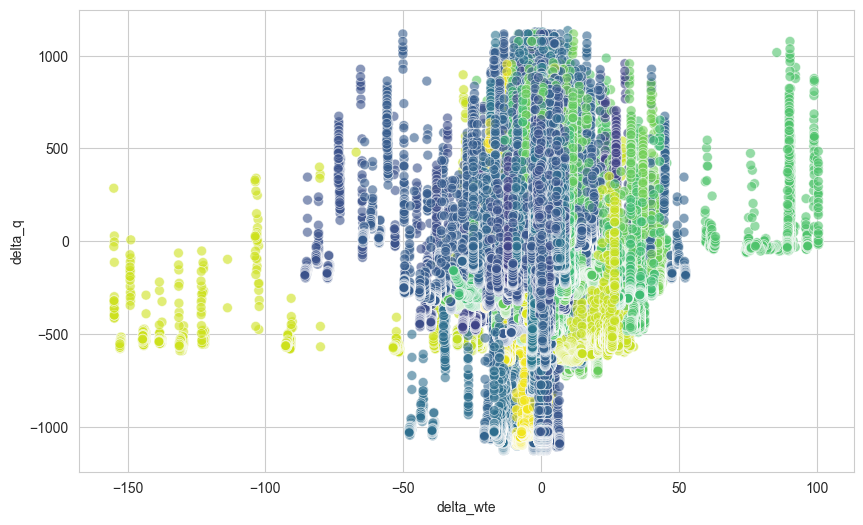

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import os

# Ensure the plots directory exists
os.makedirs('../reports/figures/seasonal/delta_q_vs_delta_wte_by_gage_seasonal', exist_ok=True)

# Define season mapping function
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Load the data
final_result_cleaned = pd.read_csv('../data/features/q_buffer2_pair_delta_30m.csv')

# Re-merge with gage_class to ensure 'class' column exists
final_result_cleaned['gage_id'] = final_result_cleaned['gage_id'].astype(str)
gage_class['STAID'] = gage_class['STAID'].astype(str)

# Merge to add CLASS column
final_result_cleaned = final_result_cleaned.merge(
    gage_class[['STAID', 'CLASS']],
    left_on='gage_id',
    right_on='STAID',
    how='left'
)

# Clean up and rename
final_result_cleaned.drop('STAID', axis=1, inplace=True)
final_result_cleaned.rename(columns={'CLASS': 'class'}, inplace=True)

# Prepare a list to collect statistical data for CSV
stats_data = []

# Convert date to datetime and extract season information
final_result_cleaned['date'] = pd.to_datetime(final_result_cleaned['date'])
final_result_cleaned['month'] = final_result_cleaned['date'].dt.month
final_result_cleaned['season'] = final_result_cleaned['month'].apply(get_season)

# Group by gage_id
grouped = final_result_cleaned.groupby('gage_id')

# Iterate over each gage
for gage_id, gage_group in grouped:
    # Get unique seasons for this gage
    unique_seasons = sorted(gage_group['season'].unique())

    # Skip if no seasonal data
    if len(unique_seasons) == 0:
        continue

    # Create plots for each season
    for season in unique_seasons:
        # Filter data for current season
        seasonal_data = gage_group[gage_group['season'] == season].copy()

        # Drop NaN values
        seasonal_data = seasonal_data.dropna(subset=['delta_wte', 'delta_q'])

        # Skip if not enough data points
        if len(seasonal_data) < 2:
            continue

        # Convert delta_q to acre-ft/year
        seasonal_data['delta_q_acre_ft_year'] = seasonal_data['delta_q'] * 365.25

        # Create the plot
        plt.figure(figsize=(10, 6))

        # Scatter plot with different colors for different wells
        sns.scatterplot(
            x='delta_wte',
            y='delta_q_acre_ft_year',
            data=seasonal_data,
            hue='well_id',
            palette='viridis',
            alpha=0.6,
            s=50,
            legend=False  # We'll create our own legend
        )

        # Perform linear regression if there's variation in delta_wte
        if len(seasonal_data['delta_wte'].unique()) > 1:
            slope, intercept, r_value, p_value, std_err = linregress(
                seasonal_data['delta_wte'], seasonal_data['delta_q_acre_ft_year']
            )

            # Plot the regression line
            sns.regplot(
                x='delta_wte',
                y='delta_q_acre_ft_year',
                data=seasonal_data,
                scatter=False,
                color='red',
                line_kws={'linewidth': 2}
            )

            # Collect statistics
            stats_data.append({
                'gage_id': gage_id,
                'season': season,
                'num_wells': seasonal_data['well_id'].nunique(),
                'num_measurements': len(seasonal_data),
                'slope': slope,
                'intercept': intercept,
                'r_squared': r_value ** 2,
                'p_value': p_value,
                'std_err': std_err,
                'class': seasonal_data['class'].iloc[0] if 'class' in seasonal_data.columns else 'Unknown'
            })

            # Statistical text
            stats_text = (
                f"Wells: {seasonal_data['well_id'].nunique()}\n"
                f"Measurements: {len(seasonal_data)}\n"
                f"Slope: {slope:.2f} (acre-ft/year)/ft\n"
                f"R²: {r_value**2:.3f}\n"
                f"P-value: {p_value:.4f}"
            )
        else:
            stats_text = (
                f"Wells: {seasonal_data['well_id'].nunique()}\n"
                f"Measurements: {len(seasonal_data)}\n"
                "All delta_wte values identical\nNo regression line"
            )

        # Map class names for display (with safety check)
        if 'class' in seasonal_data.columns and not seasonal_data['class'].isna().all():
            class_display = seasonal_data['class'].iloc[0]
            if class_display == 'Non-ref':
                class_display = 'Unregulated'
            elif class_display == 'Ref':
                class_display = 'Regulated'
        else:
            class_display = 'Unknown'

        # Add title and labels
        plt.title(f'Gage {gage_id} - {season} - Class: {class_display}\nDelta Q (acre-ft/year) vs Delta WTE', fontsize=14)
        plt.xlabel('Delta WTE (ft)', fontsize=12)
        plt.ylabel('Delta Q (acre-ft/year)', fontsize=12)
        plt.grid(True, alpha=0.3)

        # Add statistical text box
        plt.text(
            0.05, 0.95,
            stats_text,
            transform=plt.gca().transAxes,
            fontsize=10,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black')
        )

        # Save the plot
        plt.savefig(f'../reports/figures/seasonal/delta_q_vs_delta_wte_by_gage_seasonal/gage_{gage_id}_{season}_delta_q_vs_delta_wte.png',
                    bbox_inches='tight', dpi=300)
        plt.close()

# Export statistics to CSV
if stats_data:
    stats_df = pd.DataFrame(stats_data)
    stats_df.to_csv('../reports/figures/seasonal/delta_q_vs_delta_wte_seasonal_statistics.csv', index=False)

    # Print summary statistics by season
    print("Seasonal Summary Statistics:")
    for season in sorted(stats_df['season'].unique()):
        season_data = stats_df[stats_df['season'] == season]

        print(f"\n{season}:")
        print(f"  Number of gage-season combinations: {len(season_data)}")
        print(f"  Average R²: {season_data['r_squared'].mean():.3f}")
        print(f"  Median R²: {season_data['r_squared'].median():.3f}")
        print(f"  Positive slope percentage: {(season_data['slope'] > 0).mean() * 100:.1f}%")
        print(f"  Average slope: {season_data['slope'].mean():.2f} (acre-ft/year)/ft")

    # Overall statistics
    print(f"\nOverall Statistics:")
    print(f"Total gage-season combinations: {len(stats_df)}")
    print(f"Average R²: {stats_df['r_squared'].mean():.3f}")
    print(f"Percentage with positive slope: {(stats_df['slope'] > 0).mean() * 100:.1f}%")
    print(f"Number of unique gages: {stats_df['gage_id'].nunique()}")
    print(f"Number of seasons represented: {stats_df['season'].nunique()}")

else:
    print("No valid data for regression analysis")


In [34]:
# Simple seasonal statistical report - Positive slope percentage and R²
def generate_simple_seasonal_report(stats_df):
    """
    Generate a simple seasonal report showing percentage of positive slopes and R² values
    """
    print("SEASONAL STATISTICAL REPORT")
    print("=" * 60)

    # Define seasons based on months
    def get_season(month_name):
        if month_name in ['December', 'January', 'February']:
            return 'Winter'
        elif month_name in ['March', 'April', 'May']:
            return 'Spring'
        elif month_name in ['June', 'July', 'August']:
            return 'Summer'
        elif month_name in ['September', 'October', 'November']:
            return 'Fall'
        return 'Unknown'

    # Add season column if it doesn't exist
    if 'season' not in stats_df.columns:
        if 'month_name' in stats_df.columns:
            stats_df['season'] = stats_df['month_name'].apply(get_season)
        else:
            # If we only have season column already, use it directly
            pass

    # Season order for proper display
    season_order = ['Spring', 'Summer', 'Fall', 'Winter']

    # Create summary for each season
    seasonal_results = []

    for season in season_order:
        if season in stats_df['season'].values:
            season_data = stats_df[stats_df['season'] == season]

            # Calculate statistics for Delta Q
            total_records = len(season_data)
            positive_slopes_delta_q = (season_data['slope_delta_q'] > 0).sum()
            positive_percentage_delta_q = (positive_slopes_delta_q / total_records) * 100
            mean_r_squared_delta_q = season_data['r_squared_delta_q'].mean()

            # Calculate statistics for WTE
            positive_slopes_wte = (season_data['slope_wte'] > 0).sum()
            positive_percentage_wte = (positive_slopes_wte / total_records) * 100
            mean_r_squared_wte = season_data['r_squared_wte'].mean()

            seasonal_results.append({
                'Season': season,
                'Total_Records': total_records,
                'Positive_Slopes_Delta_Q_Percentage': positive_percentage_delta_q,
                'Mean_R_Squared_Delta_Q': mean_r_squared_delta_q,
                'Positive_Slopes_WTE_Percentage': positive_percentage_wte,
                'Mean_R_Squared_WTE': mean_r_squared_wte
            })

            print(f"{season:12} | Records: {total_records:3d} | Positive Slopes Delta Q: {positive_percentage_delta_q:5.1f}% | Mean R² Delta Q: {mean_r_squared_delta_q:.3f}")
            print(f"{'':12} | {'':13} | Positive Slopes WTE: {positive_percentage_wte:5.1f}% | Mean R² WTE: {mean_r_squared_wte:.3f}")
            print("-" * 60)

    # Overall statistics
    total_all = len(stats_df)
    positive_all_delta_q = (stats_df['slope_delta_q'] > 0).sum()
    positive_pct_all_delta_q = (positive_all_delta_q / total_all) * 100
    mean_r2_all_delta_q = stats_df['r_squared_delta_q'].mean()

    positive_all_wte = (stats_df['slope_wte'] > 0).sum()
    positive_pct_all_wte = (positive_all_wte / total_all) * 100
    mean_r2_all_wte = stats_df['r_squared_wte'].mean()

    print(f"{'OVERALL':12} | Records: {total_all:3d} | Positive Slopes Delta Q: {positive_pct_all_delta_q:5.1f}% | Mean R² Delta Q: {mean_r2_all_delta_q:.3f}")
    print(f"{'':12} | {'':13} | Positive Slopes WTE: {positive_pct_all_wte:5.1f}% | Mean R² WTE: {mean_r2_all_wte:.3f}")

    # Export to CSV
    results_df = pd.DataFrame(seasonal_results)
    results_df.to_csv('../reports/figures/seasonal/simple_seasonal_delta_q_wte_report.csv', index=False)

    return results_df

# Load seasonal statistics and generate seasonal report
seasonal_stats = pd.read_csv('../reports/figures/seasonal/delta_q_delta_wte_seasonal_statistics.csv')
simple_seasonal_report = generate_simple_seasonal_report(seasonal_stats)


FileNotFoundError: [Errno 2] No such file or directory: '../reports/figures/seasonal/delta_q_delta_wte_seasonal_statistics.csv'

# check the bands

In [26]:
import numpy as np

In [35]:
final_result_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2348083 entries, 0 to 2348082
Data columns (total 17 columns):
 #   Column      Dtype         
---  ------      -----         
 0   well_id     int64         
 1   date        datetime64[ns]
 2   wte         float64       
 3   gse         float64       
 4   gage_id     object        
 5   well_lat    float64       
 6   well_lon    float64       
 7   gage_lat    float64       
 8   gage_lon    float64       
 9   wte_meters  float64       
 10  q           float64       
 11  bfd         float64       
 12  delta_wte   float64       
 13  delta_q     float64       
 14  class       object        
 15  month       int32         
 16  season      object        
dtypes: datetime64[ns](1), float64(11), int32(1), int64(1), object(3)
memory usage: 295.6+ MB


Gage 10163000 清理前记录数: 561947
Gage 10163000 中delta_wte > 1000的记录数: 14
Gage 10163000 清理后记录数: 561835
井的数量: 159


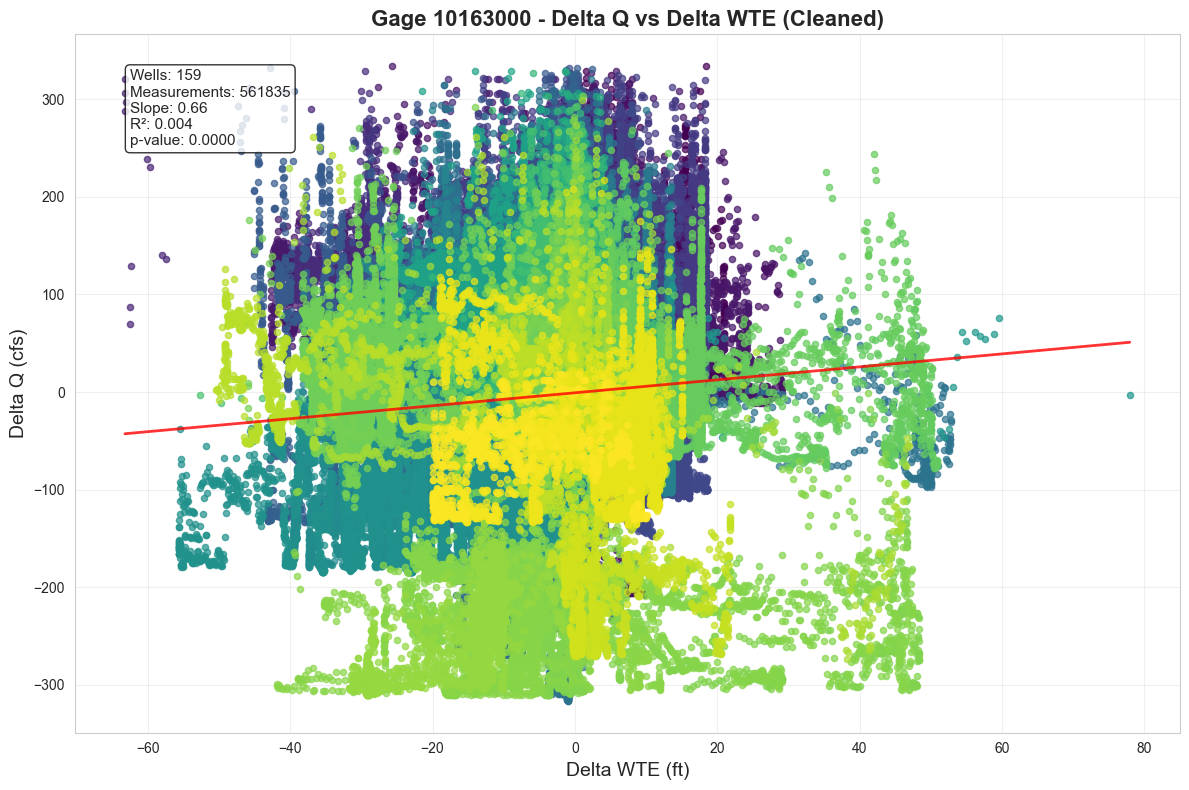

散点图已保存到: ../reports/figures/gage_10163000_cleaned_scatter.png


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import linregress

# 加载数据
final_result_cleaned = pd.read_csv('../data/features/q_buffer2_pair_delta_30m.csv')
final_result_cleaned['date'] = pd.to_datetime(final_result_cleaned['date'])

# 使用int类型的gage_id
target_gage = 10163000

# 清理gage 10163000的数据：去除delta_wte > 1000的记录
print(f"Gage {target_gage} 清理前记录数: {len(final_result_cleaned[final_result_cleaned['gage_id'] == target_gage])}")
gage_data_before = final_result_cleaned[final_result_cleaned['gage_id'] == target_gage]
print(f"Gage {target_gage} 中delta_wte > 1000的记录数: {(gage_data_before['delta_wte'] > 100).sum()}")

# 移除异常值
gage_data = final_result_cleaned[
    (final_result_cleaned['gage_id'] == target_gage) & 
    (final_result_cleaned['delta_wte'] <= 80)&
    (final_result_cleaned['delta_wte'] >= -80)
].dropna(subset=['delta_wte', 'delta_q']).copy()

print(f"Gage {target_gage} 清理后记录数: {len(gage_data)}")

if len(gage_data) == 0:
    print("没有有效数据可以绘图")
else:
    wells = gage_data['well_id'].unique()
    print(f"井的数量: {len(wells)}")

    # 创建散点图
    plt.figure(figsize=(12, 8))
    
    # 设置颜色
    colors = plt.cm.viridis(np.linspace(0, 1, len(wells)))
    
    # 为每个井绘制不同颜色的点
    for i, well_id in enumerate(wells):
        well_data = gage_data[gage_data['well_id'] == well_id]
        if len(well_data) > 0:
            plt.scatter(well_data['delta_wte'], well_data['delta_q'], 
                       color=colors[i], label=f'Well {well_id:.0f}', alpha=0.7, s=20)

    # 进行线性回归
    if len(gage_data) >= 2 and len(gage_data['delta_wte'].unique()) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(
            gage_data['delta_wte'], gage_data['delta_q']
        )
        
        # 绘制回归线
        delta_wte_range = np.linspace(gage_data['delta_wte'].min(), gage_data['delta_wte'].max(), 100)
        plt.plot(delta_wte_range, intercept + slope * delta_wte_range, 'r-', linewidth=2, alpha=0.8)
        
        # 统计信息
        stats_text = (
            f"Wells: {len(wells)}\n"
            f"Measurements: {len(gage_data)}\n"
            f"Slope: {slope:.2f}\n"
            f"R²: {r_value**2:.3f}\n"
            f"p-value: {p_value:.4f}"
        )
    else:
        stats_text = (
            f"Wells: {len(wells)}\n"
            f"Measurements: {len(gage_data)}\n"
            f"Insufficient data for regression"
        )

    # 设置图表属性
    plt.xlabel('Delta WTE (ft)', fontsize=14)
    plt.ylabel('Delta Q (cfs)', fontsize=14)
    plt.title(f'Gage {target_gage} - Delta Q vs Delta WTE (Cleaned)', fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # 添加图例（如果井不太多）
    if len(wells) <= 10:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    # 添加统计信息框
    plt.text(0.05, 0.95, stats_text, 
            transform=plt.gca().transAxes, fontsize=11,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black'),
            verticalalignment='top')

    plt.tight_layout()
    plt.savefig(f'../reports/figures/gage_{target_gage}_cleaned_scatter.png', bbox_inches='tight', dpi=300)
    plt.show()

    print(f"散点图已保存到: ../reports/figures/gage_{target_gage}_cleaned_scatter.png")

# time ser

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime

print("=== Time Series Plots for Each Gage: WTE and Q ===")

# Ensure output directory exists
os.makedirs('../reports/figures/well_timeseries_by_gage', exist_ok=True)

# Load data
final_result_cleaned = pd.read_csv('../data/features/q_buffer2_pair_delta_30m.csv')
final_result_cleaned['date'] = pd.to_datetime(final_result_cleaned['date'])

print(f"Total records loaded: {len(final_result_cleaned):,}")

# Load gage class information
gage_class = pd.read_excel('../data/raw/streamflow/GAGES-II_ref_non_ref.xlsx')
final_result_cleaned['gage_id'] = final_result_cleaned['gage_id'].astype(str)
gage_class['STAID'] = gage_class['STAID'].astype(str)

# Merge with class information
final_result_cleaned = final_result_cleaned.merge(
    gage_class[['STAID', 'CLASS']],
    left_on='gage_id',
    right_on='STAID',
    how='left'
)
final_result_cleaned.drop('STAID', axis=1, inplace=True)
final_result_cleaned.rename(columns={'CLASS': 'class'}, inplace=True)

# Group by gage_id
grouped = final_result_cleaned.groupby('gage_id')
print(f"Number of gages to process: {len(grouped)}")

# Create time series plots for each gage
for gage_id, group in grouped:
    print(f"Processing Gage {gage_id}...")
    
    # Clean data
    group = group.dropna(subset=['wte', 'q', 'date']).copy()
    if len(group) < 2:
        print(f"Skipping Gage {gage_id} - insufficient data")
        continue
    
    # Sort by date
    group = group.sort_values('date')
    
    # Get class information
    class_display = 'Unknown'
    if 'class' in group.columns and not group['class'].isna().all():
        class_val = group['class'].iloc[0]
        if class_val == 'Non-ref':
            class_display = 'Unregulated'
        elif class_val == 'Ref':
            class_display = 'Regulated'
        else:
            class_display = str(class_val) if pd.notna(class_val) else 'Unknown'
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    
    # Get unique wells for this gage and assign distinct colors
    wells = group['well_id'].unique()
    # Use a color palette that provides distinct colors for each well
    if len(wells) <= 10:
        colors = plt.cm.tab10(np.linspace(0, 1, 10))[:len(wells)]
    else:
        colors = plt.cm.viridis(np.linspace(0, 1, len(wells)))
    
    # Top subplot: WTE time series (scatter plot, no lines)
    for i, well_id in enumerate(wells):
        well_data = group[group['well_id'] == well_id].sort_values('date')
        if len(well_data) > 1:
            ax1.scatter(well_data['date'], well_data['wte'], 
                       color=colors[i], alpha=0.7, s=8,
                       label=f'Well {well_id:.0f}')
    
    ax1.set_ylabel('Water Table Elevation (ft)', fontsize=12)
    ax1.set_title(f'Gage {gage_id} - Class: {class_display}\nWater Table Elevation Time Series', 
                 fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Add well count and date range info for WTE (fix line breaks)
    date_range = f"{group['date'].min().strftime('%Y-%m-%d')} to {group['date'].max().strftime('%Y-%m-%d')}"
    wte_stats = f"Wells: {len(wells)}\nRecords: {len(group):,}\nPeriod: {date_range}\nWTE Range: {group['wte'].min():.1f} - {group['wte'].max():.1f} ft"
    
    ax1.text(0.02, 0.98, wte_stats, transform=ax1.transAxes, 
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add legend if not too many wells (with line breaks)
    if len(wells) <= 8:
        # Calculate number of columns for legend to force line breaks
        ncol = min(2, len(wells))  # Maximum 2 columns
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=ncol)
    
    # Bottom subplot: Q time series (scatter plot, no lines)
    # For Q, we typically have one value per date per gage, so plot as scatter
    q_data = group[['date', 'q']].drop_duplicates('date').sort_values('date')
    
    ax2.scatter(q_data['date'], q_data['q'], 
               color='blue', alpha=0.8, s=10)
    
    ax2.set_ylabel('Streamflow Q (cfs)', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_title('Streamflow Time Series', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Add Q statistics (fix line breaks)
    q_stats = f"Q Records: {len(q_data):,}\nQ Range: {q_data['q'].min():.1f} - {q_data['q'].max():.1f} cfs\nQ Mean: {q_data['q'].mean():.1f} cfs\nQ Median: {q_data['q'].median():.1f} cfs"
    
    ax2.text(0.02, 0.98, q_stats, transform=ax2.transAxes, 
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Format date axis
    ax2.tick_params(axis='x', rotation=45)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save plot
    plt.savefig(f'../reports/figures/well_timeseries_by_gage/gage_{gage_id}_wte_q_timeseries.png', 
                bbox_inches='tight', dpi=300)
    plt.close()

print("\nTime series plotting completed!")
print("Plots saved to: ../reports/figures/well_timeseries_by_gage/")

=== Time Series Plots for Each Gage: WTE and Q ===
Total records loaded: 2,348,083
Number of gages to process: 6
Processing Gage 10126000...
Processing Gage 10141000...
Processing Gage 10143500...
Processing Gage 10152000...
Processing Gage 10163000...
Processing Gage 10168000...

Time series plotting completed!
Plots saved to: ../reports/figures/well_timeseries_by_gage/


# the whole basin